In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import RBFSampler

warnings.filterwarnings("ignore")

### Loading Train Data
Load the train data and seperate target

In [2]:
train_data = pd.read_csv("./Data_train.csv")
train_data = train_data.drop("Unnamed: 0", axis=1)
X_train = train_data.iloc[:,[0,1]]
Y_train = train_data.iloc[:,[2]]
train_data.head()

,x,y,class
0,9.478938,-4.950071,1
1,-8.476344,3.635107,3
2,4.080771,-3.684994,3
3,-0.509729,-5.700655,2
4,-0.898476,-4.007790,3


### Loading Test Data
Load the test data and seperate target

In [3]:
test_data = pd.read_csv("./Data_test.csv")
test_data = test_data.drop("Unnamed: 0", axis=1)
X_test = test_data.iloc[:,[0,1]]
Y_test = test_data.iloc[:,[2]]
test_data.head()

,x,y,class
0,2.597513,-1.720239,1
1,7.951270,6.252087,2
2,-6.913355,4.858647,3
3,-2.948122,-0.585784,3
4,0.865727,-3.874243,3


### Task 0: Naïve Logistic Regression 
Data provided has been classifed into more than 2 classes. Multinomial Logistic Regression is used to classify
data which belongs to more than two classes. The loss function will be cross entropy for such scenario. Task 0 will evaluate
the original data. A error matrix is visualized alogn with accuracy values.

Train Accuracy: 0.362
Test Accuracy: 0.348


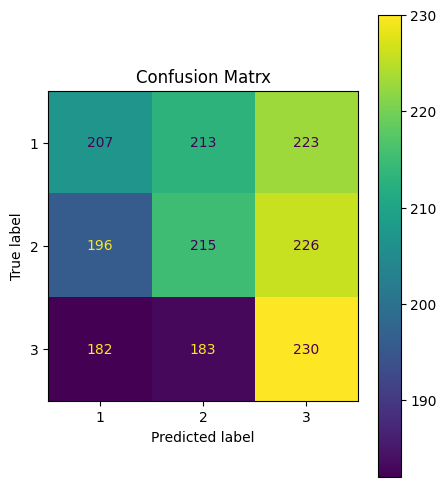

In [4]:
def Logistic_Regression(X_train,X_test,Y_train,Y_test):
    LogR_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
    cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    KFold_scores = cross_val_score(LogR_model, X_train, Y_train, scoring='accuracy', cv=cross_validation, n_jobs=-1)
    train_accuracy = np.mean(KFold_scores)
    LogR_model.fit(X_train,Y_train)
    test_accuracy = LogR_model.score(X_test, Y_test)
        
    return LogR_model, train_accuracy, test_accuracy

LogR_model, train_accuracy, test_accuracy = Logistic_Regression(X_train,X_test,Y_train,Y_test)
print('Train Accuracy: %.3f' % train_accuracy)
print('Test Accuracy: %.3f' % test_accuracy)

fig, ax = plt.subplots(figsize=(5, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(LogR_model, X_test, Y_test.values.flatten(), ax = ax)

### Classification Report

In [46]:
print(metrics.classification_report(Y_test, LogR_model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.35      0.32      0.34       643
           2       0.35      0.34      0.34       637
           3       0.34      0.39      0.36       595

    accuracy                           0.35      1875
   macro avg       0.35      0.35      0.35      1875
weighted avg       0.35      0.35      0.35      1875



## Visualize the original data

<AxesSubplot: xlabel='x', ylabel='y'>

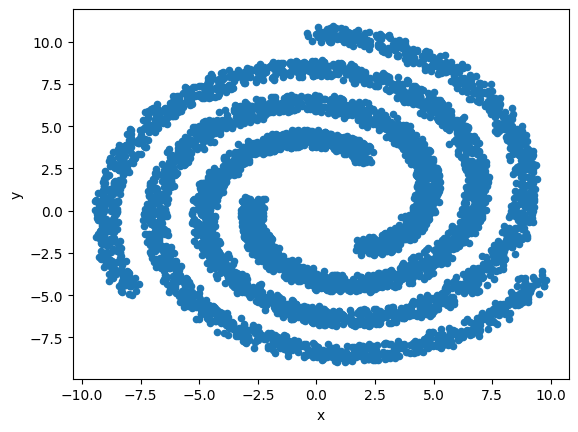

In [6]:
X_train.plot.scatter(x='x',y='y')

# Task 1 : Train Data Transformation 
We transform the orginal data into feature space using polynomial Kernel. Kernels transform the non-linea data into linear data. This could also be done using PCA. We need to divide the sprial data set into 4 quadrents to make the data linear. It is a hectic process. So we go with kernel. Here, we use degree 2 polynomial kernel.

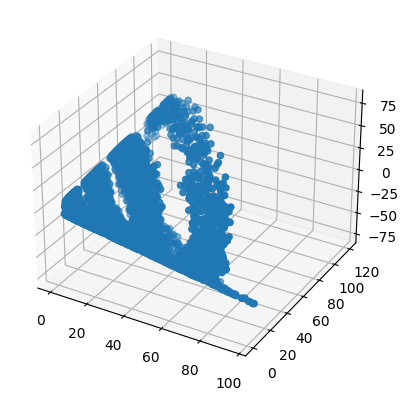

In [45]:
#Kernel 1
def polynomial_2_degree_kernel(X):
    x1_sqr = X['x'] ** 2
    x2_sqr = X['y'] ** 2
    x1_x2 = 1.41 * X['x'] * X['y']
    
    return np.column_stack([x1_sqr, x2_sqr, x1_x2])
        
transformed_train_data = polynomial_2_degree_kernel(X_train)
transformed_test_data = polynomial_2_degree_kernel(X_test)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(transformed_train_data[:,0],transformed_train_data[:,1], transformed_train_data[:,2])

## 4 Assumptions of logistic regression
To be able apply linear models, the data should obey few assumptions. These assumptions were verified below for train data that was transformed into new space.
1. The outcome should be either binomial or multinomial classes
2. The length of the dataset should exceed 500
3. Absence of multicolinearity. This can be verified using variance inflation factor.
4. Linearity of independent variables. We use log odds to verfiy this assumption.

In [24]:
#Assumption 1
print('Unique classes : %d' % Y_train['class'].nunique())
        

Unique classes : 3


In [47]:
#Assumption 2
print('Length of Dataset : %d' % transformed_train_data.shape[0])

Length of Dataset : 5625


In [48]:
#Assumption 3
vif = pd.DataFrame()
dataframe = pd.DataFrame(transformed_train_data, columns = ['x1^2','x2^2','x1*x2'])
vif["variables"] = dataframe.columns
vif["Variance_Inflation_Factor"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
count = 0
for i in  vif['Variance_Inflation_Factor']:
    if(i>5):
        count = count + 1
print('Number of features having problematic amount of multicolinearity : %d' % count)

Number of features having problematic amount of multicolinearity : 0


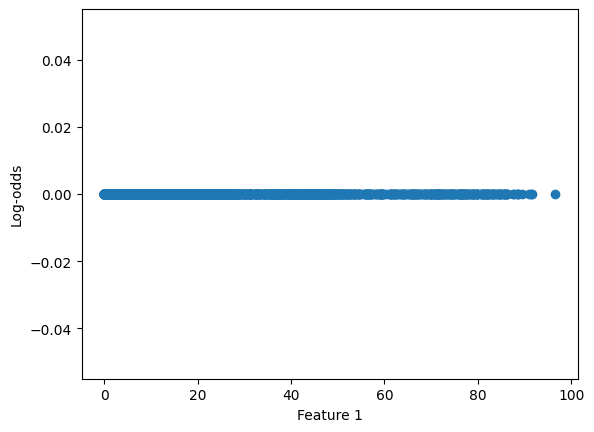

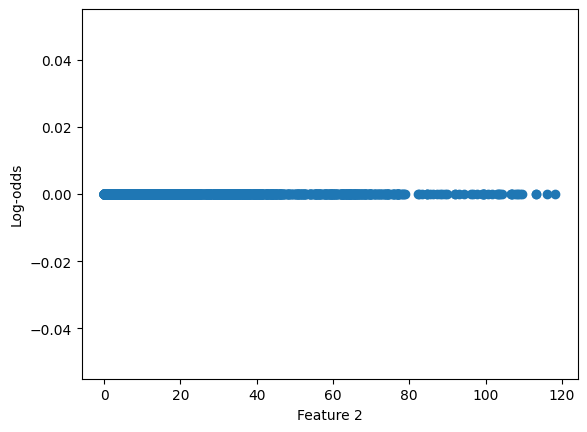

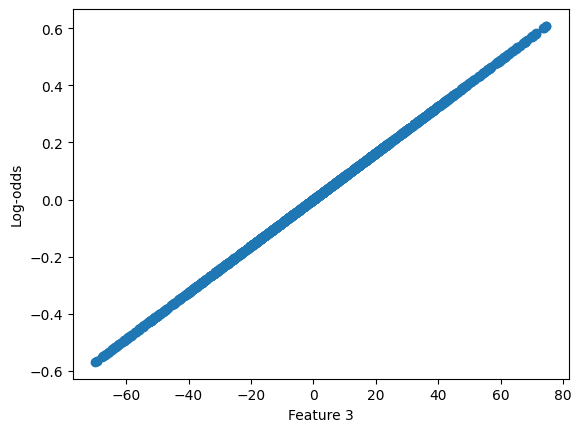

In [49]:
#Assumption 4
for feature in range(transformed_train_data.shape[1]):
    logit_results = GLM(Y_train, transformed_train_data[:, feature], family=families.Binomial()).fit()
    p = logit_results.predict(transformed_test_data[:, feature].reshape(-1, 1))
        
    log_odds = np.log(p / (1 - p))
    log_odds = np.where(log_odds == np.inf, 0, log_odds)

    plt.scatter(x=transformed_test_data[:, feature], y=log_odds)
    plt.xlabel(f"Feature {feature + 1}")
    plt.ylabel("Log-odds")
    plt.show()

# Task 2 : Linear Parametric Classification 
We use scikit-learn logistic regression method to evaluate the degree 2 polynomial kernel transfromed data.We find it coefficients and then we use gridSearchCV to tune the hyperparameters. We will take 100 different coefficents ranging between 10e-5 to 10e-5. We will also evaulate on limited memory BFGS, liblinear solvers and observe there performences. We pick the best mobel after hyper tuning, fit the data with it and evaluate using test data.

Weights of the untuned model:
[[-0.00422421  0.00193641 -0.00610417]
 [ 0.00077619  0.00222582  0.00709119]
 [ 0.00344802 -0.00416222 -0.00098702]]

Test data accuracy of the untuned model: 0.3589333333333333

Train data accuracy of best model from grid search cv: 0.365


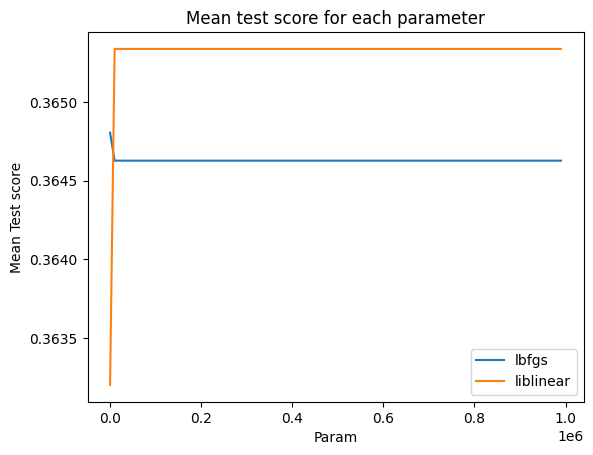

Test data evaluation of best fit model from grid search cv: 0.359


In [9]:
def Linear_Parametric_Classification(transformed_train_data, transformed_test_data, Y_train, Y_test):
    
    #Task 2a
    untuned_model,train_accuracy, test_accuracy = Logistic_Regression(transformed_train_data, transformed_test_data, 
                                                                      Y_train,Y_test)
    print(f"Weights of the untuned model:\n{untuned_model.coef_}\n")
    print(f"Test data accuracy of the untuned model: {test_accuracy}\n")
    
    #Task 2b
    LogR_model_tune = LogisticRegression(penalty='l2',random_state=42)
    r = np.linspace(10e-5,10e5,100,endpoint=False)
    solver = ['lbfgs','liblinear']
    param = {'C': r, 'solver':solver}
    hypertuned_model = GridSearchCV(LogR_model_tune, param, cv=10)
    hypertuned_model.fit(transformed_train_data, Y_train)
    results = pd.DataFrame(hypertuned_model.cv_results_)
    best_model = hypertuned_model.best_estimator_

    print("Train data accuracy of best model from grid search cv: %.3f" % results['mean_test_score'].max())
    
    for s in solver:
        evaluated_score = results[results['param_solver'] == s][['param_C', 'mean_test_score']]
        plt.plot(evaluated_score['param_C'], evaluated_score['mean_test_score'], label=s)
    plt.xlabel("Param")
    plt.ylabel("Mean Test score")  
    plt.title("Mean test score for each parameter")
    plt.legend()
    plt.show()
    
    return best_model

best_model = Linear_Parametric_Classification(transformed_train_data, transformed_test_data, Y_train, Y_test)

#Task 2c
accuracy = best_model.score(transformed_test_data, Y_test)
print('Test data evaluation of best fit model from grid search cv: %.3f' % accuracy)

# Task 3 : Transformation using Kernel Method 
We have used one kernel already to make data linear. We will implement 4 other kernels and evaulate the respective transformed data using the Task 2 code i.e we will evaluate the data with and without hypertuning on logistic regression parameters. We will pick the best model in the collection of hypertuned models and evalute it with test data.

## Kernel 2 : Linear Kernel
We will try exponenting the very basic linear kernel. The mathamatial equation of this kernel is k(x,y) = (x,y)

Weights of the untuned model:
[[-0.0086941  -0.046578  ]
 [ 0.04352109  0.01751435]
 [-0.03482698  0.02906365]]

Test data accuracy of the untuned model: 0.34773333333333334

Train data accuracy of best model from grid search cv: 0.364


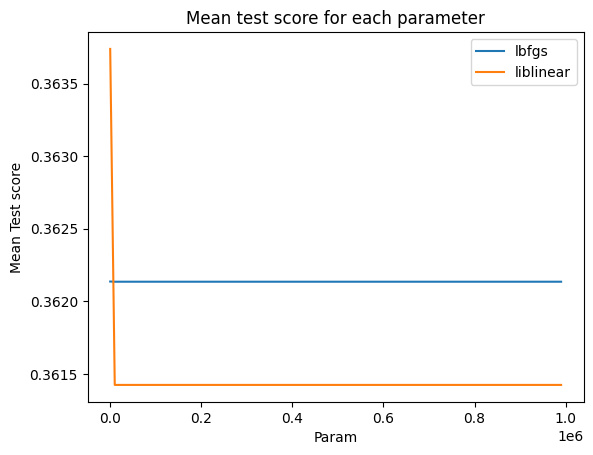

Test data evaluation with best fit model give accuracy 0.344


In [26]:
def Linear_kernel(X_train):
    x1=X_train['x']
    x2=X_train['y']
    
    x = x1
    y = x2
    
    return np.column_stack([x,y])

tnsf_linear_train = Linear_kernel(X_train)
tnsf_linear_test = Linear_kernel(X_test)
bst_linear_model = Linear_Parametric_Classification(tnsf_linear_train, tnsf_linear_test, Y_train, Y_test)
accuracy = bst_linear_model.score(tnsf_linear_test, Y_test)
print('Test data evaluation with best fit model give accuracy %.3f' % accuracy)

## Kernel 3 : 4 degree polynomial kernel
We will use 4 degree polynomial kernel. The mathamatical equation of it is k(x,y) = (x^4, 2x^3y, sqrt(3)x^2y^2, 2xy^3, y^4).

Weights of the untuned model:
[[-1.53326590e-04 -8.61074388e-05  1.18128290e-04 -9.58456581e-05
  -3.46852341e-06]
 [ 5.84036820e-05  3.53787719e-05 -6.31327311e-05  1.91887289e-04
   7.86741788e-06]
 [ 9.49229084e-05  5.07286669e-05 -5.49955590e-05 -9.60416308e-05
  -4.39889446e-06]]

Test data accuracy of the untuned model: 0.3808

Train data accuracy of best model from grid search cv: 0.385


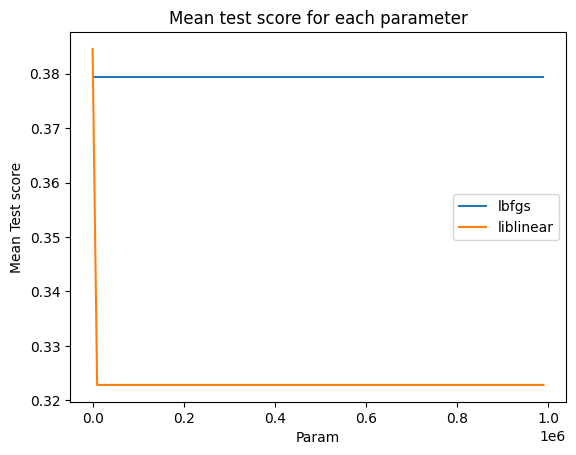

Test data evaluation with best fit model give accuracy 0.384


In [11]:
def transform_BiQuadratic(X_train):
    x1=X_train['x']
    x2=X_train['y']
    
    x3 = x1 * x1 * x1 *x1
    x3y = 2 * (x1**3) * x2
    x2y2 = 1.73 * (x1**2) * (x2**2)
    xy3 = 2 * x1 * (x2**3)
    y4 = x2 * x2 * x2 *x2
    
    return np.column_stack([x4,x3y,x2y2,xy3,y4])

tnsf_bi_quad_train = transform_BiQuadratic(X_train)
tnsf_bi_quad_test = transform_BiQuadratic(X_test)
bst_bi_quad_model = Linear_Parametric_Classification(tnsf_bi_quad_train, tnsf_bi_quad_test, Y_train, Y_test)
accuracy = bst_bi_quad_model.score(tnsf_bi_quad_test, Y_test)
print('Test data evaluation with best fit model give accuracy %.3f' % accuracy)

## Kenrel 4 : Hyperbolic Tangent Kernel Function
This kernel is generally used in neural networks. Yet, this is a valid function. The mathematical function is k(x,y) = tanh(kxy+c) or k(x,y) = tanh((sqrt(k)x,sqrt(k)y))

Weights of the untuned model:
[[ 0.05874668 -0.08273913]
 [ 0.07524915  0.1232782 ]
 [-0.13399582 -0.04053907]]

Test data accuracy of the untuned model: 0.37546666666666667

Train data accuracy of best model from grid search cv: 0.397


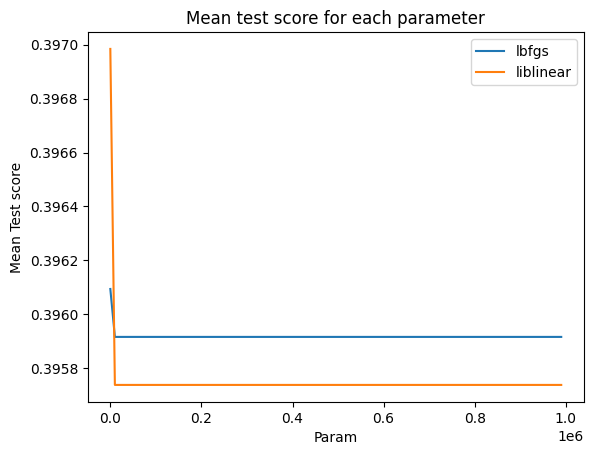

Test data evaluation with best fit model give accuracy 0.375


In [27]:
def hyperbolic_tangent(X_train):
    x1=X_train['x']
    x2=X_train['y']
    sqrtk = 1.73 #sqaure root of 3
    sqrtkx = sqrtk*x1
    sqrtky = sqrtk*x2
    tanh = np.tanh(np.column_stack([sqrtkx,sqrtky]))
    return tanh
tnsf_hyp_tan_train = hyperbolic_tangent(X_train)
tnsf_hyp_tan_test = hyperbolic_tangent(X_test)
bst_hyb_tan_model = Linear_Parametric_Classification(tnsf_hyp_tan_train, tnsf_hyp_tan_test, Y_train, Y_test)
accuracy = bst_hyb_tan_model.score(tnsf_hyp_tan_test, Y_test)
print('Test data evaluation with best fit model give accuracy %.3f' % accuracy)

## Kernel 5 : Guassan RBF Kernel
Guassina RBF kernel assumes, that the data is normally distributed. The transformed data will also be in gassian or normally distributed.

In [44]:
def gaussin_rbf(X_train, X_test):
    rbf = RBFSampler(gamma=2, random_state=5)
    tnsf_gaussian_train = rbf.fit_transform(X_train)
    tnsf_gaussian_test = rbf.transform(X_test)
    return tnsf_gaussian_train, tnsf_gaussian_test

tnsf_gaussian_train, tnsf_gaussian_test = gaussin_rbf(X_train, X_test)
guassian_model = LogisticRegression(penalty='l2',random_state=42)
train_accuracy = guassian_model.fit(tnsf_gaussian_train, Y_train)
test_accuracy = guassian_model.score(tnsf_gaussian_test, Y_test)
print(f"Weights of the untuned guassian model:\n{guassian_model.coef_}\n")
print('Test data accuracy of the untuned guassian model %.3f\n' % test_accuracy)
print('Observation : Guassian kernel is taking very long time while executing gridsearchcv for 100 values')

Weights of the untuned guassian model:
[[ 2.14112082 -3.56260938 -0.07611596 -5.26402193  1.69754648 -0.20770251
  -0.78169269  0.52293503  0.62714759 -4.10141584  2.5365963  -3.99866883
  -0.09879497  3.48424394  0.28213444 -0.04900083 -1.3212572   0.20979561
  -0.22701847  2.5993769  -0.48800217  0.12527617 -1.55638012  1.1987337
  -0.33182206 -2.84457545 -2.81121316  0.2663857  -0.87791916  1.9043999
   2.80728921  2.48253211 -0.73100713  0.56683876 -0.48369233  0.92737849
  -0.90442559  0.78596976 -1.06824748  0.0455107   0.02390953 -0.43704832
   0.33289179  0.96987753 -0.29535673 -0.1556      1.89747311  4.17723451
   2.45756156 -1.40145931 -0.14822953  0.5655483  -0.50880838 -2.58402962
   2.17190765 -0.38453188 -0.1062103   0.46159572 -1.01730944  4.48120226
   1.08399128  2.45569316  0.78623244  0.30454151 -0.03847359  3.12047516
  -0.86117346 -0.69170422 -0.24234666  0.56092399  1.3235071   0.59872155
  -0.58852177 -2.45100044  1.82760405  0.8887377  -2.86720559 -0.36032119
 

# Task 4: Non-parametric KNN Classification 
We will K Nearest Neighbours algorithm to classify the original and transformed datasets from different kernels. We will visualize performance of each dataset. Number of Neighbours will be between 1 to 200. 

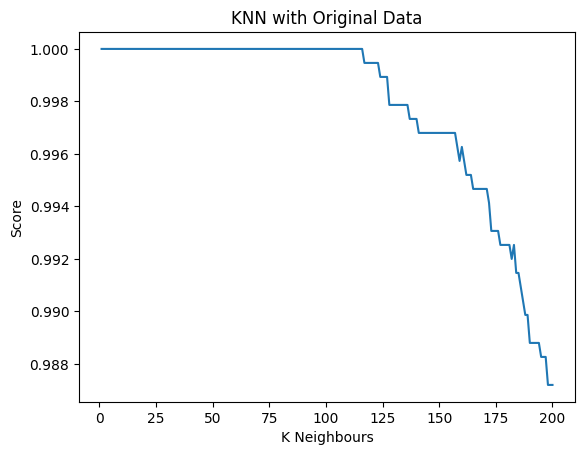

In [36]:
def kNearestNeighbours(X_train,X_test,Y_train,Y_test, kernel):
    K_neighbours = list(range(1,201))
    scores = []
    for i in K_neighbours:
        model = KNeighborsClassifier(i)
        model.fit(X_train, Y_train)
        score =  model.score(X_test,Y_test)
        scores.append(score)
    plt.plot(K_neighbours, scores)
    plt.ylabel("Score")
    plt.xlabel("K Neighbours")
    plt.title(f"KNN with {kernel}")
    plt.show()
    

kNearestNeighbours(X_train,X_test,Y_train,Y_test,'Original Data')     

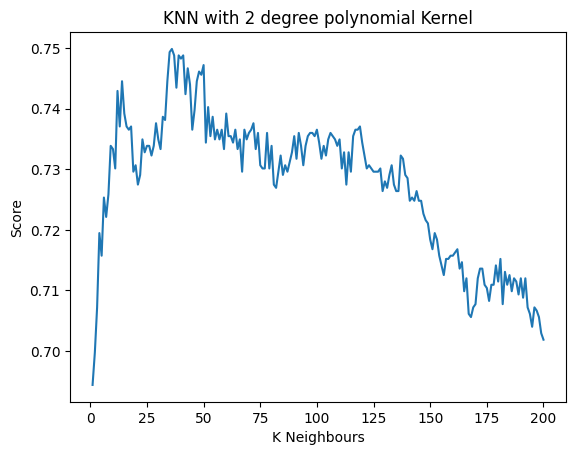

In [50]:
kNearestNeighbours(transformed_train_data,transformed_test_data,Y_train,Y_test,'2 degree polynomial Kernel') 

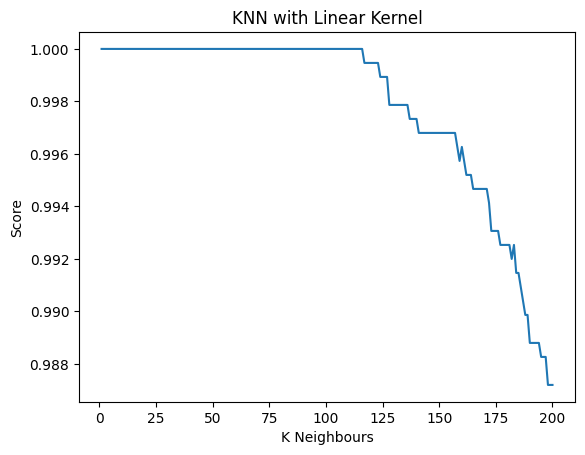

In [37]:
kNearestNeighbours(tnsf_linear_train,tnsf_linear_test,Y_train,Y_test,'Linear Kernel')

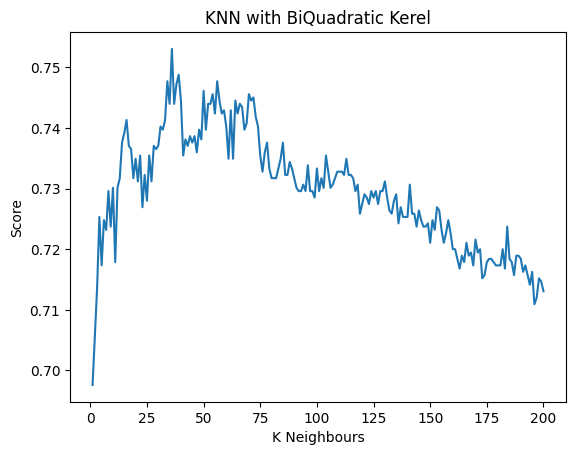

In [17]:
kNearestNeighbours(tnsf_bi_quad_train,tnsf_bi_quad_test,Y_train,Y_test,'BiQuadratic Kerel') 

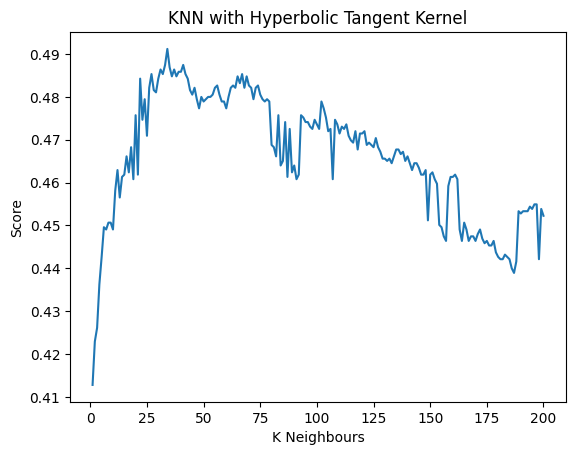

In [18]:
kNearestNeighbours(tnsf_hyp_tan_train,tnsf_hyp_tan_test,Y_train,Y_test,'Hyperbolic Tangent Kernel')

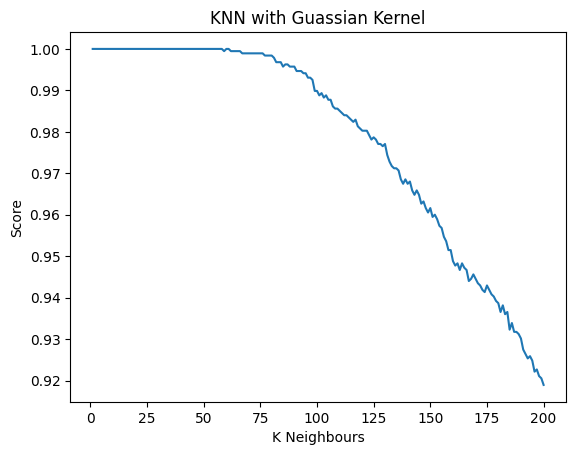

In [38]:
kNearestNeighbours(tnsf_gaussian_train,tnsf_gaussian_test,Y_train,Y_test,'Guassian Kernel')